In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

pd.set_option('display.max_columns', None)

### Controller states estimation
The file contains the estimation of the states using a Kalman filter (when detecting  the landing platform for a UAV to autonomosly land on it, the system estimates the position of the platform even when there is no detection to have a notion of where it is located) in the filed trial for the autonomous landing system of a quadcopter. The states are X and Y centroid coordinates of the platform, width, height and angle with respect to the horizontal.Two controllers were tested (P Proportional and PD Proportinal-Integral), the first one twice and the second controller was tested four times.

In the datasets each controller was tested five times, each test have six columns (timestamp, Xc, Yc, Widht, Height and angle). Each test is numerated, for example P1_Xc makes reference to the X coordinate od the platform's centroid of first test of the controller P.

In [2]:
data_file = "./data/controllerStateEstimation_fieldTrial.csv"
data = pd.read_csv(data_file)
data

,P1_time_percent,P1_Xc,P1_Yc,P1_W,P1_H,P1_angle,P2_time_percent,P2_Xc,P2_Yc,P2_W,P2_H,P2_angle,PD1_time_percent,PD1_Xc,PD1_Yc,PD1_W,PD1_H,PD1_angle,PD2_time_percent,PD2_Xc,PD2_Yc,PD2_W,PD2_H,PD2_angle,PD3_time_percent,PD3_Xc,PD3_Yc,PD3_W,PD3_H,PD3_angle,PD4_time_percent,PD4_Xc,PD4_Yc,PD4_W,PD4_H,PD4_angle
0,1.543939e+18,70.888664,75.167511,1247.065918,337.163269,-74.602921,1.543939e+18,187.124634,111.631851,87.955711,74.788818,23.399200,1.543938e+18,154.892365,185.548462,46.656868,49.330578,-1.118787,1.543938e+18,73.200615,104.222992,59.992729,55.930588,-9.967028,1.544028e+18,191.264816,92.842743,68.283112,56.800751,61.801048,1.544029e+18,149.560455,76.779243,66.608932,62.329842,-38.072502
1,1.543939e+18,68.955109,73.591110,1304.390259,351.437988,-76.673073,1.543939e+18,189.020584,112.762909,88.808434,75.513885,23.624031,1.543938e+18,154.947281,182.514130,45.548344,48.535027,-1.574557,1.543938e+18,70.683678,105.415077,59.256699,54.763008,-12.133504,1.544028e+18,191.185593,91.616280,65.254250,56.509918,64.126656,1.544029e+18,150.699051,77.363762,67.108421,62.797245,-38.357113
2,1.543939e+18,56.716663,118.877129,199.952682,89.869553,-27.561647,1.543939e+18,190.916534,113.893959,89.661148,76.238953,23.848862,1.543938e+18,155.002213,179.479797,44.439819,47.739479,-2.030327,1.543938e+18,68.166740,106.607162,58.520672,53.595425,-14.299981,1.544028e+18,191.106369,90.389824,62.225380,56.219090,66.452271,1.544029e+18,151.837646,77.948280,67.607910,63.264648,-38.641727
3,1.543939e+18,53.292007,124.081650,126.002342,72.975052,-23.848406,1.543939e+18,192.812485,115.025017,90.513870,76.964020,24.073694,1.543938e+18,155.057129,176.445465,43.331291,46.943928,-2.486097,1.543938e+18,69.443756,103.699631,58.305603,58.984966,-10.423015,1.544028e+18,186.731735,85.710449,75.642174,86.876938,62.391285,1.544029e+18,152.976257,78.532799,68.107399,63.732048,-38.926338
4,1.543939e+18,53.071220,113.919800,47.080334,53.045517,-29.526762,1.543939e+18,194.708435,116.156075,91.366585,77.689087,24.298525,1.543938e+18,155.112061,173.411148,42.222767,46.148380,-2.941867,1.543938e+18,68.141197,103.579498,57.658016,58.930580,-11.563489,1.544028e+18,185.226288,83.337494,74.989471,91.057755,63.794121,1.544029e+18,154.114853,79.117317,68.606888,64.199448,-39.210949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.544028e+18,951.612488,-136.129028,1304.570557,1011.862671,-6.503270,NaN,NaN,NaN,NaN,NaN,NaN
530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.544028e+18,956.820801,-137.662796,1311.660034,1017.045227,-6.525722,NaN,NaN,NaN,NaN,NaN,NaN
531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.544028e+18,962.029114,-139.196579,1318.749390,1022.227722,-6.548172,NaN,NaN,NaN,NaN,NaN,NaN
532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.544028e+18,967.237427,-140.730347,1325.838867,1027.410278,-6.570624,NaN,NaN,NaN,NaN,NaN,NaN


The controller_times dictionary contains the duration time of the simulation for each landing process. The time of the tests must be saved with the name of the test (as described above) in the controllerTestTime.csv file n the columns test and duration_time.

In [3]:
controller_times = {}

with open("./data/controllerFieldTime.csv", "r") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    for row in csv_reader:
        controller_times[row[0]] = float(row[1])

print(controller_times)

{'P1': 27.541, 'P2': 31.1, 'PD1': 39.585, 'PD2': 31.651, 'PD3': 63.554, 'PD4': 33.267}


Calculate the time for each sample given the total time of each test and the timestamp of the simulation (time_percent in the dataset), knowing that the relationship between the duration time of the test and the timestamp is linear. It important to notice that the starting point of the duration time of the test is zero.

$\displaystyle m = \frac{time_{total}}{timestamp_n-timestamp_0}$ where $timestamp_0$ is the first value of the timestamps, $timestamp_n$ is the last value of the timestamps and $total time$ is the duration of the test.

$\displaystyle b = m.timestamp_n + time_{total}$

The linear relantionship between the timestamp ant the duration time of the tests is :
$\displaystyle time = m.timestamp + b$

In [4]:
for test, test_time in controller_times.items():    

    first_val_tstamp = data[test+"_time_percent"][0]
    last_val_tstamp = data[test+"_time_percent"][data.apply(lambda column: column.dropna().index[-1])[test+"_time_percent"]]
    
    m = test_time / (last_val_tstamp - first_val_tstamp)
    b = test_time - m * last_val_tstamp
    
    data[test+"_time"] = m * data[test+"_time_percent"] + b
    
data = data.reindex(columns=sorted(data.columns))

Delete timestamp columns, they won't be used in further analysis.

In [5]:
droplist = [i for i in data.columns if 'time_percent' in i]
data.drop(droplist, axis=1, inplace=True)

In [6]:
data

,P1_H,P1_W,P1_Xc,P1_Yc,P1_angle,P1_time,P2_H,P2_W,P2_Xc,P2_Yc,P2_angle,P2_time,PD1_H,PD1_W,PD1_Xc,PD1_Yc,PD1_angle,PD1_time,PD2_H,PD2_W,PD2_Xc,PD2_Yc,PD2_angle,PD2_time,PD3_H,PD3_W,PD3_Xc,PD3_Yc,PD3_angle,PD3_time,PD4_H,PD4_W,PD4_Xc,PD4_Yc,PD4_angle,PD4_time
0,337.163269,1247.065918,70.888664,75.167511,-74.602921,0.000000,74.788818,87.955711,187.124634,111.631851,23.399200,0.000000,49.330578,46.656868,154.892365,185.548462,-1.118787,0.000000,55.930588,59.992729,73.200615,104.222992,-9.967028,0.000000,56.800751,68.283112,191.264816,92.842743,61.801048,0.000000,62.329842,66.608932,149.560455,76.779243,-38.072502,-2.384186e-07
1,351.437988,1304.390259,68.955109,73.591110,-76.673073,0.167236,75.513885,88.808434,189.020584,112.762909,23.624031,0.130834,48.535027,45.548344,154.947281,182.514130,-1.574557,0.314079,54.763008,59.256699,70.683678,105.415077,-12.133504,0.215570,56.509918,65.254250,191.185593,91.616280,64.126656,0.158375,62.797245,67.108421,150.699051,77.363762,-38.357113,1.025603e-01
2,89.869553,199.952682,56.716663,118.877129,-27.561647,0.351101,76.238953,89.661148,190.916534,113.893959,23.848862,0.332398,47.739479,44.439819,155.002213,179.479797,-2.030327,0.589989,53.595425,58.520672,68.166740,106.607162,-14.299981,0.464950,56.219090,62.225380,191.106369,90.389824,66.452271,0.298083,63.264648,67.607910,151.837646,77.948280,-38.641727,1.868165e-01
3,72.975052,126.002342,53.292007,124.081650,-23.848406,0.572031,76.964020,90.513870,192.812485,115.025017,24.073694,0.560205,46.943928,43.331291,155.057129,176.445465,-2.486097,0.929225,58.984966,58.305603,69.443756,103.699631,-10.423015,0.606722,86.876938,75.642174,186.731735,85.710449,62.391285,0.431065,63.732048,68.107399,152.976257,78.532799,-38.926338,2.461715e-01
4,53.045517,47.080334,53.071220,113.919800,-29.526762,0.910460,77.689087,91.366585,194.708435,116.156075,24.298525,0.775432,46.148380,42.222767,155.112061,173.411148,-2.941867,1.146973,58.930580,57.658016,68.141197,103.579498,-11.563489,0.843886,91.057755,74.989471,185.226288,83.337494,63.794121,0.523890,64.199448,68.606888,154.114853,79.117317,-39.210949,3.587766e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1011.862671,1304.570557,951.612488,-136.129028,-6.503270,63.251523,NaN,NaN,NaN,NaN,NaN,NaN
530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1017.045227,1311.660034,956.820801,-137.662796,-6.525722,63.372134,NaN,NaN,NaN,NaN,NaN,NaN
531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1022.227722,1318.749390,962.029114,-139.196579,-6.548172,63.430587,NaN,NaN,NaN,NaN,NaN,NaN
532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1027.410278,1325.838867,967.237427,-140.730347,-6.570624,63.498589,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate the mean of each state
Calulate the mean of each state of the stimation of the controllers. The mean is calulated using the  tests for each controller. As each tests have different durations, complete the NaN values of the errors with the last value of the test to obtain the mean. The longer duration time will be used to plot the measures.

In [7]:
time_columns = [i for i in data.columns if 'time' in i]
column_pos = data[time_columns].apply(lambda column: column.dropna().index[-1])

time_last_row = dict(zip(time_columns, column_pos))

print(time_last_row)

{'P1_time': 154, 'P2_time': 259, 'PD1_time': 245, 'PD2_time': 274, 'PD3_time': 533, 'PD4_time': 317}


A new dataset is created with the mean of the states for the two controllers. As mentioned above the longest time of the controllers will be used to plot the states of each controller:

 - For the P controller: from row 0 to row 259 (the longest duration test was P2).
 - For the PD controller: from row 0 to row 533 (the longest duration test was PD3).

In [8]:
mean_df = pd.DataFrame(columns = ["Time", "Controller", "Xc",
                                  "Yc", "Width", "Height", 
                                  "Angle"])

In [9]:
temp_df = pd.DataFrame()
temp_df["Time"] = data.loc[0:259, "P2_time"]
temp_df["Xc"] = data.loc[0:259, ["P1_Xc", "P2_Xc"]].mean(axis=1)
temp_df["Yc"] = data.loc[0:259, ["P1_Yc", "P2_Yc"]].mean(axis=1)
temp_df["Width"] = data.loc[0:259, ["P1_W", "P2_W"]].mean(axis=1)
temp_df["Height"] = data.loc[0:259, ["P1_H", "P2_H"]].mean(axis=1)
temp_df["Angle"] = data.loc[0:259, ["P1_angle", "P2_angle"]].mean(axis=1)
temp_df["Controller"] = "P"

mean_df = mean_df.append(temp_df, ignore_index=True) 
temp_df.drop(temp_df.index, inplace=True)

temp_df["Time"] = data.loc[0:533, "PD3_time"]
temp_df["Xc"] = data.loc[0:533, ["PD1_Xc", "PD2_Xc", "PD3_Xc", "PD4_Xc"]].mean(axis=1)
temp_df["Yc"] = data.loc[0:533, ["PD1_Yc", "PD2_Yc", "PD3_Yc", "PD4_Yc"]].mean(axis=1)
temp_df["Width"] = data.loc[0:533, ["PD1_W", "PD2_W", "PD3_W", "PD4_W"]].mean(axis=1)
temp_df["Height"] = data.loc[0:533, ["PD1_H", "PD2_H", "PD3_H", "PD4_H"]].mean(axis=1)
temp_df["Angle"] = data.loc[0:533, ["PD1_angle", "PD2_angle", "PD3_angle", "PD4_angle"]].mean(axis=1)
temp_df["Controller"] = "PD"

mean_df = mean_df.append(temp_df, ignore_index=True) 
del temp_df

In [10]:
mean_df

,Time,Controller,Xc,Yc,Width,Height,Angle
0,0.000000,P,129.006649,93.399681,667.510815,205.976044,-25.601860
1,0.130834,P,128.987846,93.177010,696.599346,213.475937,-26.524521
2,0.332398,P,123.816599,116.385544,144.806915,83.054253,-1.856393
3,0.560205,P,123.052246,119.553333,108.258106,74.969536,0.112644
4,0.775432,P,123.889828,115.037937,69.223459,65.367302,-2.614119
...,...,...,...,...,...,...,...
789,63.251523,PD,951.612488,-136.129028,1304.570557,1011.862671,-6.503270
790,63.372134,PD,956.820801,-137.662796,1311.660034,1017.045227,-6.525722
791,63.430587,PD,962.029114,-139.196579,1318.749390,1022.227722,-6.548172
792,63.498589,PD,967.237427,-140.730347,1325.838867,1027.410278,-6.570624


### Plot the states for each controller

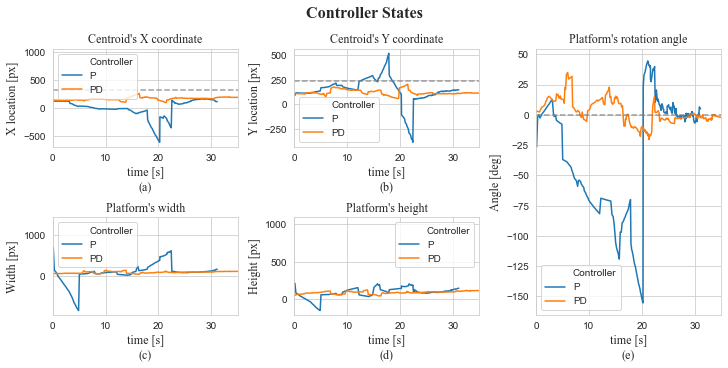

In [11]:
timesfont = {'fontname':'Times New Roman'}

sns.set_style("whitegrid")

fig = plt.figure(constrained_layout=True, figsize=(10,5))

gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])

xc = sns.lineplot(data=mean_df, x="Time", y="Xc",
             hue="Controller", ax=ax1)
yc = sns.lineplot(data=mean_df, x="Time", y="Yc",
             hue="Controller", ax=ax2)
angle = sns.lineplot(data=mean_df, x="Time", y="Angle",
             hue="Controller", ax=ax3)
w = sns.lineplot(data=mean_df, x="Time", y="Width",
             hue="Controller", ax=ax4)
h = sns.lineplot(data=mean_df, x="Time", y="Height",
             hue="Controller", ax=ax5)

xc.set_xlim(0,35)
yc.set_xlim(0,35)
angle.set_xlim(0,35)
w.set_xlim(0,35)
h.set_xlim(0,35)

xc.axhline(y=320, linewidth=1.5, color='grey', ls='--', alpha=0.75)
yc.axhline(y=240, linewidth=1.5, color='grey', ls='--', alpha=0.75)
angle.axhline(y=0, linewidth=1.5, color='grey', ls='--', alpha=0.75)

xc.set_title("Centroid's X coordinate", fontsize=12, **timesfont)
yc.set_title("Centroid's Y coordinate", fontsize=12, **timesfont)
w.set_title("Platform's width", fontsize=12, **timesfont)
h.set_title("Platform's height", fontsize=12, **timesfont)
angle.set_title("Platform's rotation angle", fontsize=12, **timesfont)

xc.set_xlabel("time [s]\n(a)", fontsize=12, **timesfont)
yc.set_xlabel("time [s]\n(b)", fontsize=12, **timesfont)
w.set_xlabel("time [s]\n(c)", fontsize=12, **timesfont)
h.set_xlabel("time [s]\n(d)", fontsize=12, **timesfont)
angle.set_xlabel("time [s]\n(e)", fontsize=12, **timesfont)

xc.set_ylabel("X location [px]", fontsize=12, **timesfont)
yc.set_ylabel("Y location [px]", fontsize=12, **timesfont)
w.set_ylabel("Width [px]", fontsize=12, **timesfont)
h.set_ylabel("Height [px]", fontsize=12, **timesfont)
angle.set_ylabel("Angle [deg]", fontsize=12, **timesfont)

fig.suptitle('Controller States', fontsize=16, fontweight='bold', **timesfont)

plt.show()